# SegmentingClients 


In [1]:
#Uploading data
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_excel('BankClients.xlsx', header=0)

#Dropping ID
df=df.drop(labels='ID' , axis=1)

Now we plot some barplot of the categorical variables to look for little frequencies that we want to summarise together in order to simplify the model before Dummy encoding.


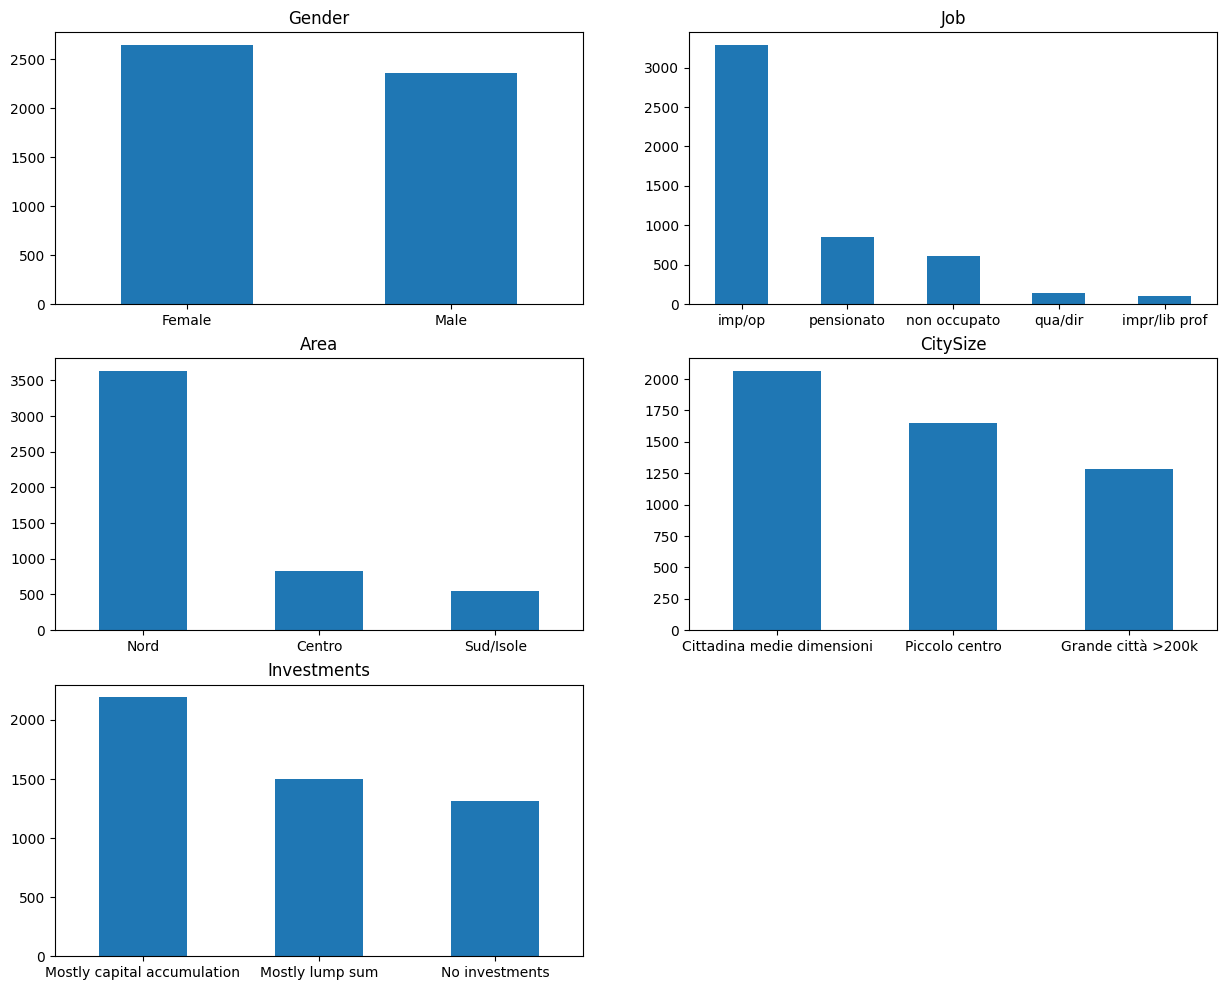

In [2]:
# Histograms of categorical features

%matplotlib inline

plt.figure(figsize = (15,12))

fig = plt.subplot(3, 2, 1)

plt.title('Gender')
df['Gender'].value_counts().plot(kind='bar')
x = [0,1]
labels = ['Female', 'Male']
plt.xticks(x, labels, rotation='horizontal')


plt.subplot(3, 2, 2)

plt.title('Job')
df['Job'].value_counts().plot(kind='bar')
x = [0,1,2,3,4]
labels = ['imp/op', 'pensionato', 'non occupato', 'qua/dir', 'impr/lib prof']
plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 3)

plt.title('Area')
df['Area'].value_counts().plot(kind='bar')
x = [0,1,2]
labels = ['Nord', 'Centro', 'Sud/Isole']
plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 4)

plt.title('CitySize')
df['CitySize'].value_counts().plot(kind='bar')
x = [0,1,2]
labels = ['Cittadina medie dimensioni', 'Piccolo centro', 'Grande città >200k']
plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 5)

plt.title('Investments')
df['Investments'].value_counts().plot(kind='bar')
x = [0,1,2]
labels = ['Mostly capital accumulation', 'Mostly lump sum', 'No investments']
plt.xticks(x, labels, rotation='horizontal')

plt.show()

All the frequencies are consistent so we preserve all the features values.

In [3]:
#dataset scaling and dummies encoding
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

df1=pd.get_dummies(df,columns=['Gender','Job','Area','CitySize','Investments'])
col_names = ['Age', 'FamilySize', 'Income', 'Wealth', 'Debt', 
              'FinEdu', 'ESG', 'Digital', 'BankFriend', 'LifeStyle',
              'Luxury', 'Saving']#names of the numerical variables to be rescaled
features = df1[col_names]
#scaler = StandardScaler().fit(features.values)
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
df1[col_names] = features

Now we plot a correlation panel to look at correlation between continous variables.

<AxesSubplot: >

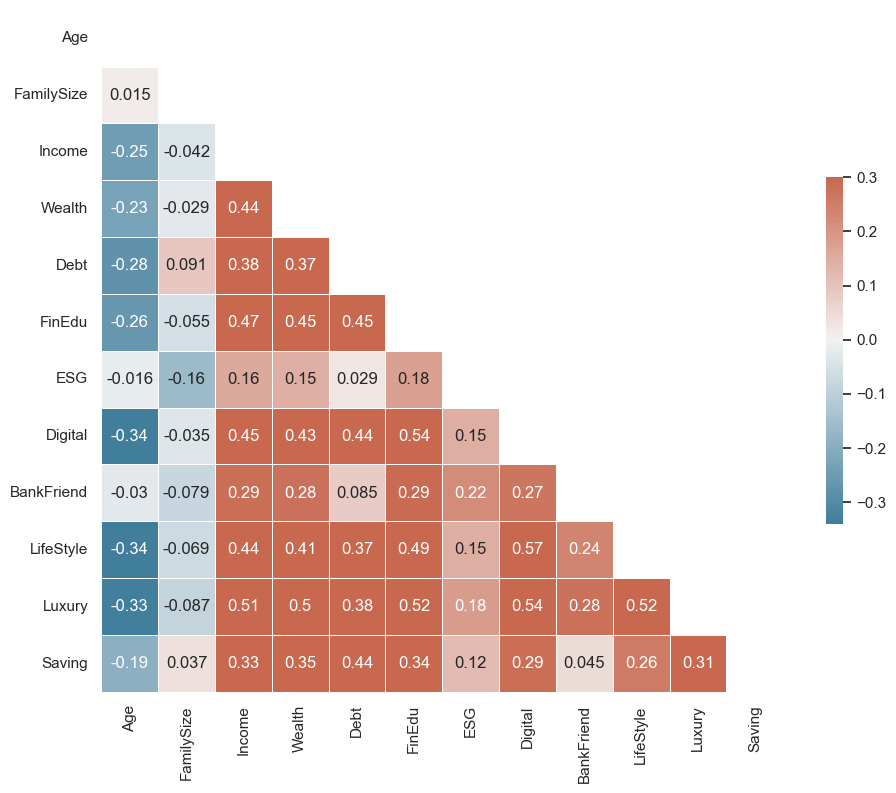

In [4]:
#Correlation Panel
import seaborn as sns
import numpy as np

# Correlation matrix
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.drop(columns=['Gender','Job','Area','CitySize','Investments']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

The "correlation of the whole continous dataset" is very low, so we don't eliminate any continuous variable.

In [5]:
from sklearn.model_selection import train_test_split

#TRAIN TEST SPLIT
rs=7 #RandomState
train,test = train_test_split(df1,test_size=0.7,random_state=rs)

# Clustering


In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances, davies_bouldin_score
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist,squareform
from sklearn import metrics
import gower

#Setting the data to use (train or df1)
data = df1

In [7]:
#Clustering with cityblock 

#Vector of distances
mhv = pdist(data, 'cityblock',)
#From vector to matrix
mh = squareform(mhv,force='tomatrix')

k_cand =[i for i in range(2,7)]

# find k clusters
results_kmedoids_cb = dict()#Creates a dictionary

for k in k_cand:
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0,2,size=k)
    kmedoids_instance = kmedoids(mh,
                                 initial_medoids,
                                 data_type='distance_matrix')    

    # run cluster analysis and obtain results
    %time kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    score1 = silhouette_score(mh, cluster_array, metric='precomputed')
    score2 = metrics.calinski_harabasz_score(data, cluster_array)
    score3 = davies_bouldin_score(data, cluster_array)
    
    # store
    results_kmedoids_cb[k] = {'k':cluster_array,'score':score1,'ch-score': score2, 'db-score': score3}

CPU times: total: 9.94 s
Wall time: 15.5 s
CPU times: total: 12.4 s
Wall time: 18.4 s
CPU times: total: 14.3 s
Wall time: 21.5 s
CPU times: total: 15.1 s
Wall time: 25.5 s
CPU times: total: 29.3 s
Wall time: 51.9 s


In [8]:
#Clustering with Gower

#Gower distance matrix
gow=gower.gower_matrix(data)

results_kmedoids_gow = dict()#Creates a dictionary

for k in k_cand:
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0,2,size=k)
    kmedoids_instance_gow = kmedoids(gow,
                                 initial_medoids,
                                 data_type='distance_matrix')    

    # run cluster analysis and obtain results
    %time kmedoids_instance_gow.process()
    clusters_gow = kmedoids_instance_gow.get_clusters()
    medoids_gow = kmedoids_instance_gow.get_medoids()

    # convert cluster output
    cluster_array_gow = pd.DataFrame([(x,e) for e,i in enumerate(clusters_gow) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    score1 = silhouette_score(gow, cluster_array_gow, metric='precomputed')
    score2 = metrics.calinski_harabasz_score(data, cluster_array_gow)
    score3 = davies_bouldin_score(data, cluster_array_gow)
    
    # store
    results_kmedoids_gow[k] = {'k':cluster_array_gow,'score':score1,'ch-score': score2, 'db-score': score3}

CPU times: total: 8.59 s
Wall time: 15.2 s
CPU times: total: 19.7 s
Wall time: 28.9 s
CPU times: total: 15.8 s
Wall time: 26.5 s
CPU times: total: 12.9 s
Wall time: 23.5 s
CPU times: total: 26.2 s
Wall time: 42.7 s


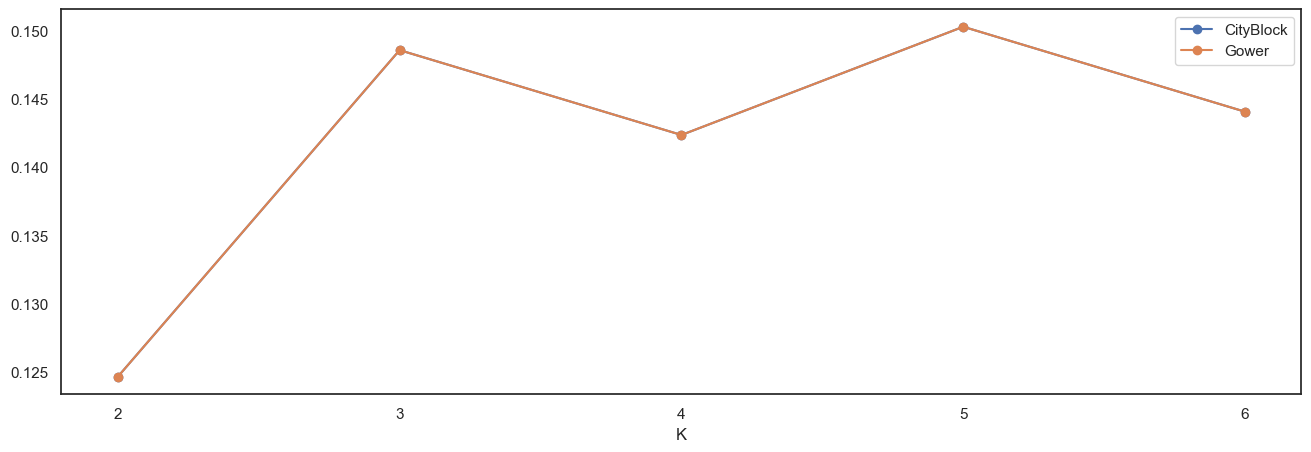

In [9]:
#Plot silhouette score
fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results_kmedoids_cb.keys()],[i['score'] for i in results_kmedoids_cb.values()],'o-',label='CityBlock')
axs.plot([i for i in results_kmedoids_gow.keys()],[i['score'] for i in results_kmedoids_gow.values()],'o-',label='Gower')
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

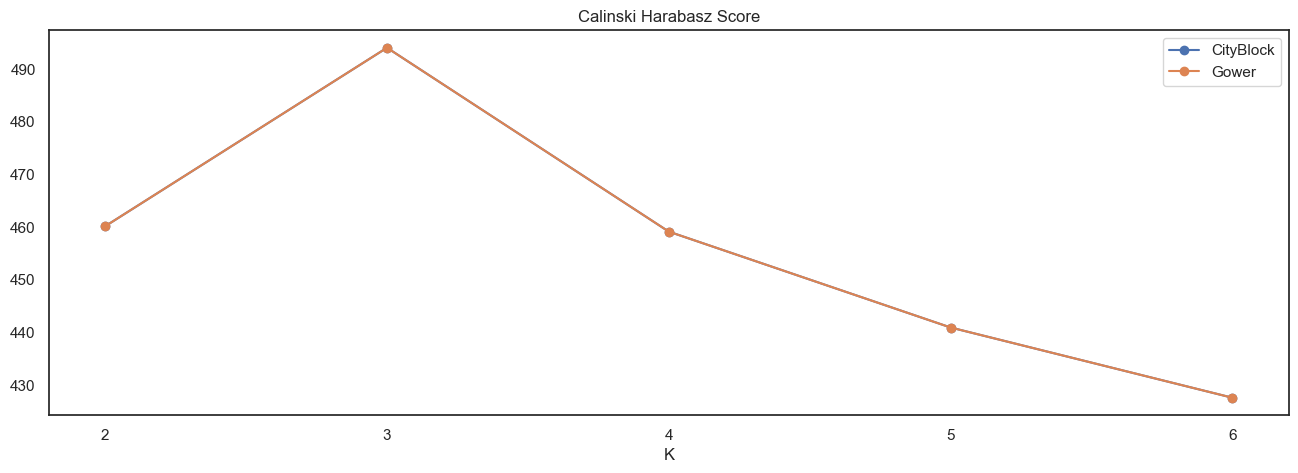

In [10]:
%matplotlib inline

# Plot Calinski Harabasz score

fig,axs = plt.subplots(1,1,figsize=(16,5))
plt.title('Calinski Harabasz Score')
axs.plot([i for i in results_kmedoids_cb.keys()],[i['ch-score'] for i in results_kmedoids_cb.values()],'o-',label='CityBlock')
axs.plot([i for i in results_kmedoids_gow.keys()],[i['ch-score'] for i in results_kmedoids_gow.values()],'o-',label='Gower')
axs.set_xticks(range(2,7))
axs.set_xlabel('K')
axs.legend()
plt.show()

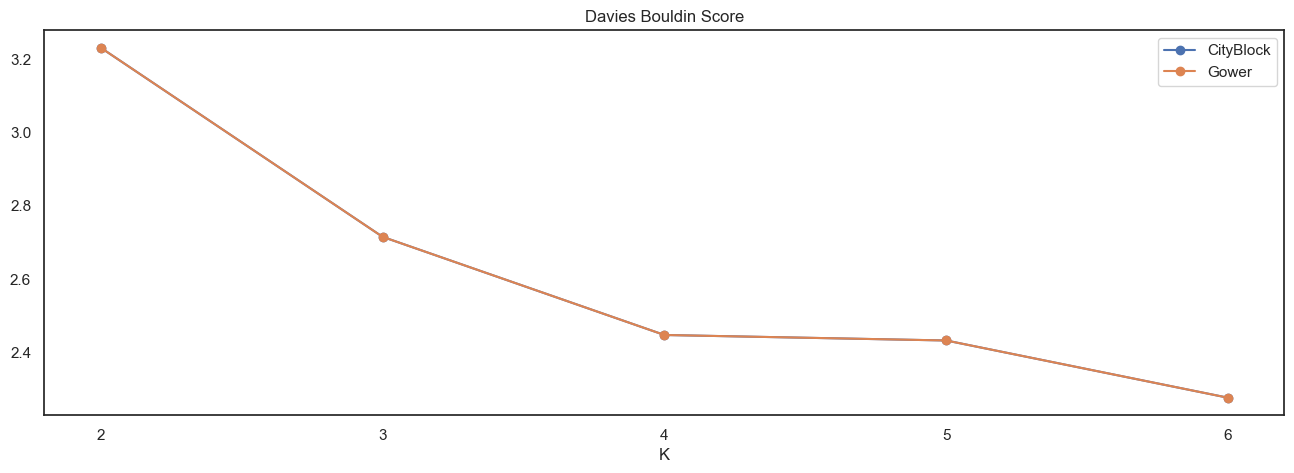

In [11]:
%matplotlib inline

# Plot Davies Bouldin score

fig,axs = plt.subplots(1,1,figsize=(16,5))
plt.title('Davies Bouldin Score')
axs.plot([i for i in results_kmedoids_cb.keys()],[i['db-score'] for i in results_kmedoids_cb.values()],'o-',label='CityBlock')
axs.plot([i for i in results_kmedoids_gow.keys()],[i['db-score'] for i in results_kmedoids_gow.values()],'o-',label='Gower')
axs.set_xticks(range(2,7))
axs.set_xlabel('K')
axs.legend()
plt.show()

# PCA

Text(0, 0.5, 'Cumulative Explainend Variance')

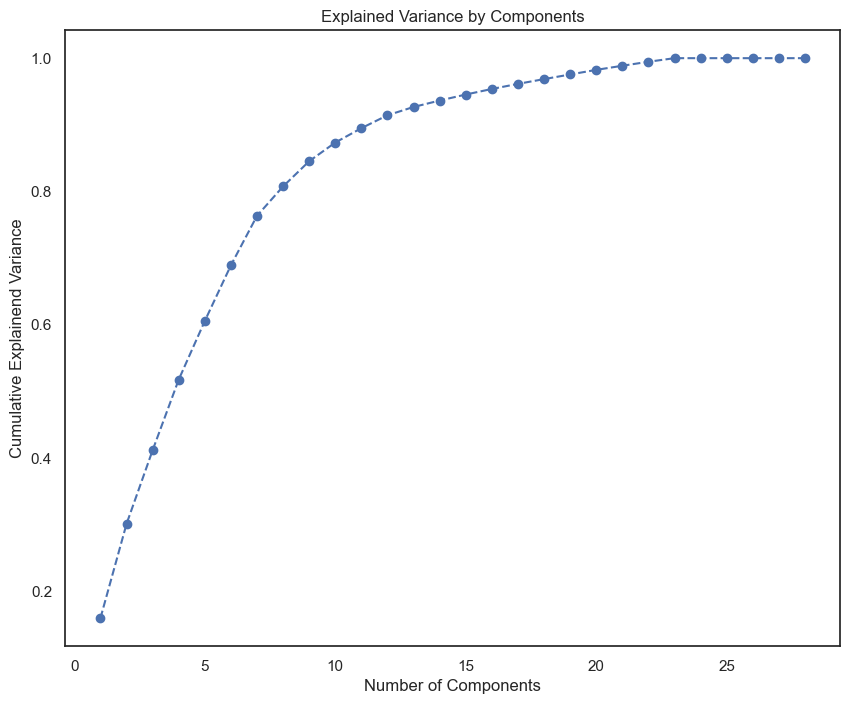

In [12]:
#PCA reduction (in order to improve the performance of our algorithm)
from sklearn.decomposition import PCA

#fit data using PCA
pca = PCA()
pca.fit(data)

#variace explained by each components
pca.explained_variance_ratio_

#plot of the explained Variance by components

plt.figure(figsize = (10,8))
plt.plot(range(1,29), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explainend Variance')

In [13]:
#A rule of thumb is to preserve around 80 % of the variance

ncomponents = 8

#perform PCA and obtain PCA scores
pca = PCA(n_components = ncomponents)
pca.fit(data)
scores_pca = pca.transform(data)

In [14]:
#Clustering with cityblock after PCA

#Vector of distances
mhv = pdist(scores_pca, 'cityblock',)
#From vector to matrix
mh = squareform(mhv,force='tomatrix')

k_cand =[i for i in range(2,7)]

# find k clusters
results_kmedoids_cb_PCA = dict()#Creates a dictionary

for k in k_cand:
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0,2,size=k)
    kmedoids_instance = kmedoids(mh,
                                 initial_medoids,
                                 data_type='distance_matrix')    

    # run cluster analysis and obtain results
    %time kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    score1 = silhouette_score(mh, cluster_array, metric='precomputed')
    score2 = metrics.calinski_harabasz_score(scores_pca, cluster_array)
    score3 = davies_bouldin_score(scores_pca, cluster_array)
    
    # store
    results_kmedoids_cb_PCA[k] = {'k':cluster_array,'score':score1,'ch-score': score2, 'db-score': score3}
    

CPU times: total: 9.27 s
Wall time: 11.8 s
CPU times: total: 14.3 s
Wall time: 19.6 s
CPU times: total: 23 s
Wall time: 30.1 s
CPU times: total: 21.9 s
Wall time: 30.4 s
CPU times: total: 29.7 s
Wall time: 43.8 s


In [15]:
#Clustering with Gower after reduction
#Gower distance matrix
gow=gower.gower_matrix(scores_pca)

results_kmedoids_gow_PCA = dict()#Creates a dictionary

for k in k_cand:
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0,2,size=k)
    kmedoids_instance_gow = kmedoids(gow,
                                 initial_medoids,
                                 data_type='distance_matrix')    

    # run cluster analysis and obtain results
    %time kmedoids_instance_gow.process()
    clusters_gow = kmedoids_instance_gow.get_clusters()
    medoids_gow = kmedoids_instance_gow.get_medoids()

    # convert cluster output
    cluster_array_gow = pd.DataFrame([(x,e) for e,i in enumerate(clusters_gow) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    score1 = silhouette_score(gow, cluster_array_gow, metric='precomputed')
    score2 = metrics.calinski_harabasz_score(scores_pca, cluster_array_gow)
    score3 = davies_bouldin_score(scores_pca, cluster_array_gow)
    
    # store
    results_kmedoids_gow_PCA[k] = {'k':cluster_array_gow,'score':score1,'ch-score': score2, 'db-score': score3}

CPU times: total: 12 s
Wall time: 20 s
CPU times: total: 13.2 s
Wall time: 21 s
CPU times: total: 19.3 s
Wall time: 28 s
CPU times: total: 24.8 s
Wall time: 35.3 s
CPU times: total: 28.2 s
Wall time: 49.9 s


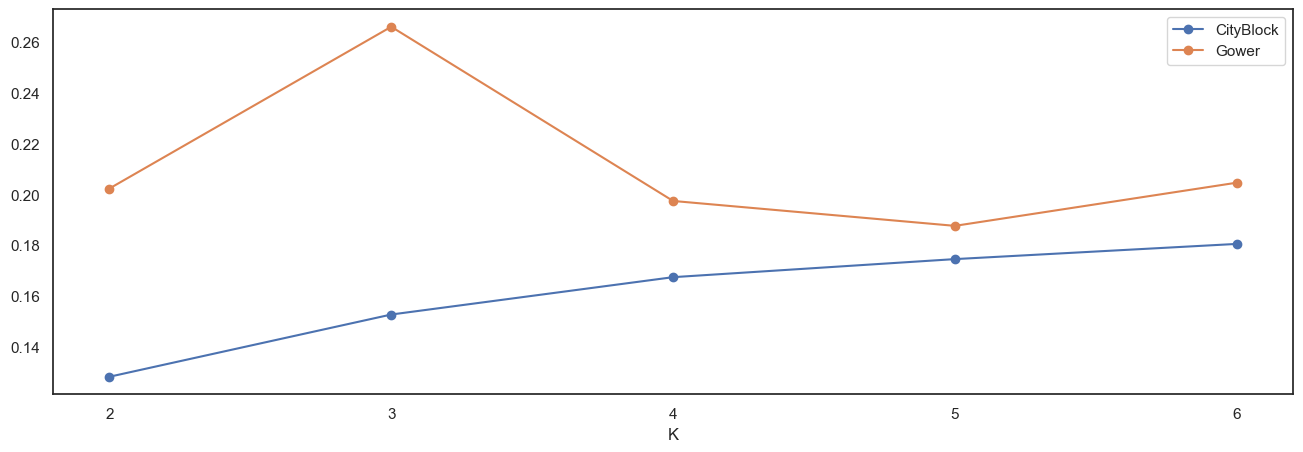

In [16]:
#Plot silhouette_score after PCA
fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results_kmedoids_cb_PCA.keys()],[i['score'] for i in results_kmedoids_cb_PCA.values()],'o-',label='CityBlock')
axs.plot([i for i in results_kmedoids_gow_PCA.keys()],[i['score'] for i in results_kmedoids_gow_PCA.values()],'o-',label='Gower')
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

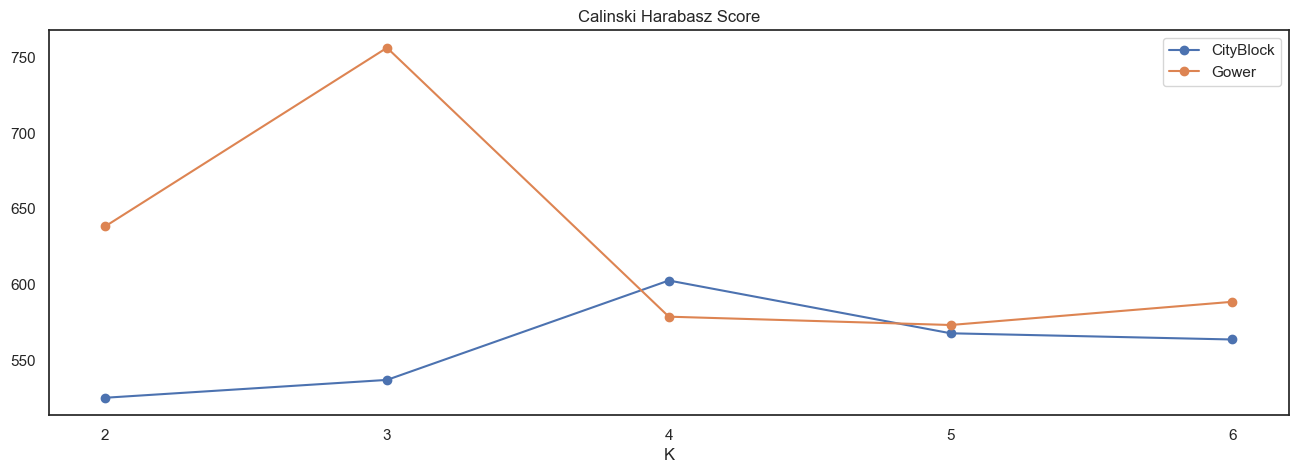

In [17]:
%matplotlib inline

# Plot Calinski Harabasz score

fig,axs = plt.subplots(1,1,figsize=(16,5))
plt.title('Calinski Harabasz Score')
axs.plot([i for i in results_kmedoids_cb_PCA.keys()],[i['ch-score'] for i in results_kmedoids_cb_PCA.values()],'o-',label='CityBlock')
axs.plot([i for i in results_kmedoids_gow_PCA.keys()],[i['ch-score'] for i in results_kmedoids_gow_PCA.values()],'o-',label='Gower')
axs.set_xticks(range(2,7))
axs.set_xlabel('K')
axs.legend()
plt.show()

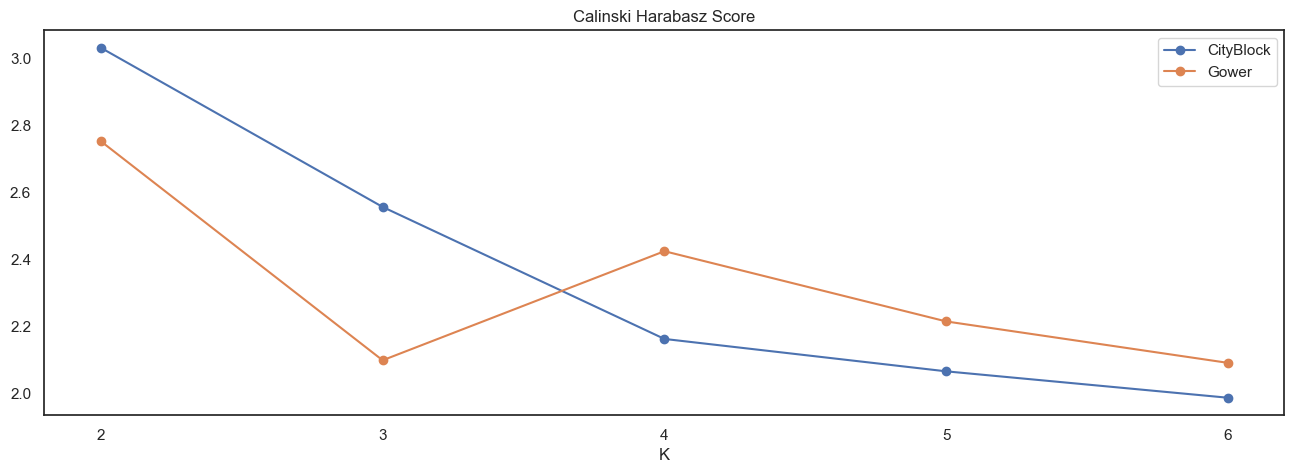

In [18]:
%matplotlib inline

# Plot Davies Bouldin score

fig,axs = plt.subplots(1,1,figsize=(16,5))
plt.title('Calinski Harabasz Score')
axs.plot([i for i in results_kmedoids_cb_PCA.keys()],[i['db-score'] for i in results_kmedoids_cb_PCA.values()],'o-',label='CityBlock')
axs.plot([i for i in results_kmedoids_gow_PCA.keys()],[i['db-score'] for i in results_kmedoids_gow_PCA.values()],'o-',label='Gower')
axs.set_xticks(range(2,7))
axs.set_xlabel('K')
axs.legend()
plt.show()

<IPython.core.display.Javascript object>


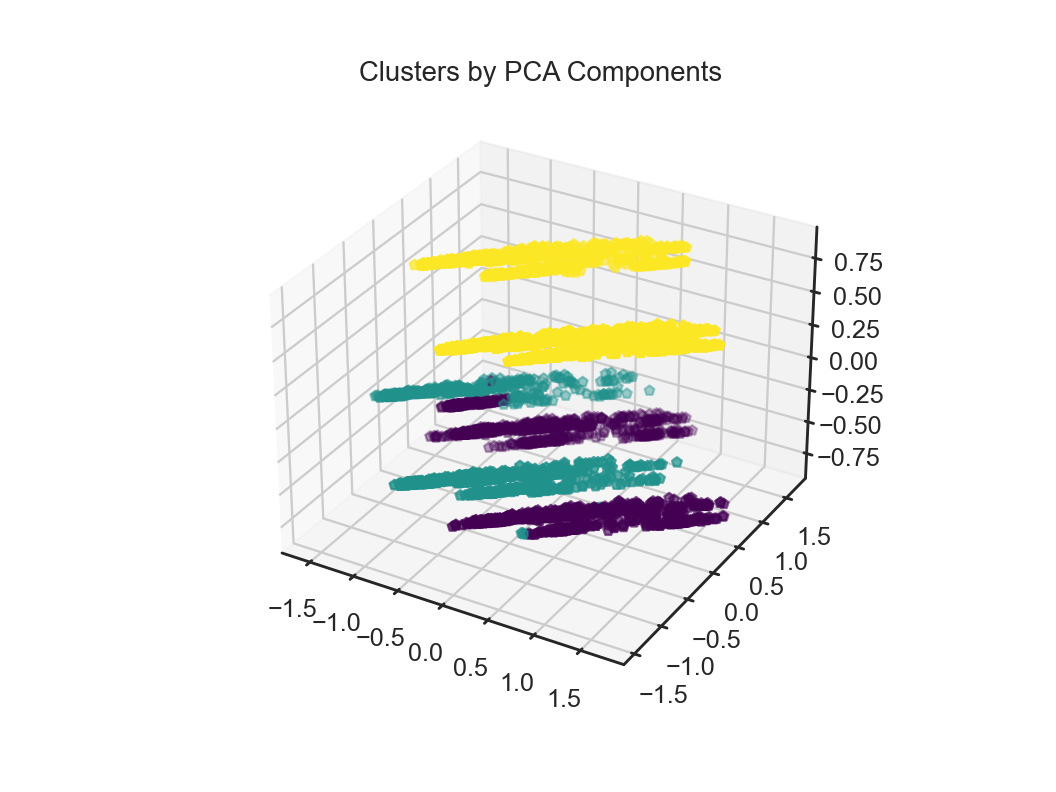

In [44]:
#Segments visualization 
%matplotlib notebook
#optimal_cluster_array=results_kmedoids_cb_PCA[3]['k']
optimal_cluster_array=results_kmedoids_gow_PCA[3]['k']
data_ad = pd.concat([pd.DataFrame(scores_pca, columns = ['Component {0:d}'.format(i+1) for i in range(ncomponents)]), 
                     pd.DataFrame(optimal_cluster_array, columns = ['Segment k-medoids PCA'])], axis = 1) 
data_ad['Segment'] = data_ad['Segment k-medoids PCA'].map({0:'first',1:'second',2:'third'})

#Plot data by PCA components

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x_axis = data_ad['Component 1']
y_axis = data_ad['Component 2']
z_axis = data_ad['Component 3']

ax.scatter(x_axis, y_axis, z_axis, marker="p", c = data_ad['Segment k-medoids PCA'] , cmap = "viridis")
plt.title('Clusters by PCA Components')
plt.show()

## Business Analysis

In [20]:
optimal_cluster_array=results_kmedoids_gow_PCA[3]['k']

In [21]:
dfba = pd.concat([df,pd.DataFrame(optimal_cluster_array, columns = ['cluster'])], axis=1)

df0 = dfba[dfba['cluster']==0].drop(labels='cluster' , axis=1)

df1 = dfba[dfba['cluster']==1].drop(labels='cluster' , axis=1)

df2 = dfba[dfba['cluster']==2].drop(labels='cluster' , axis=1)

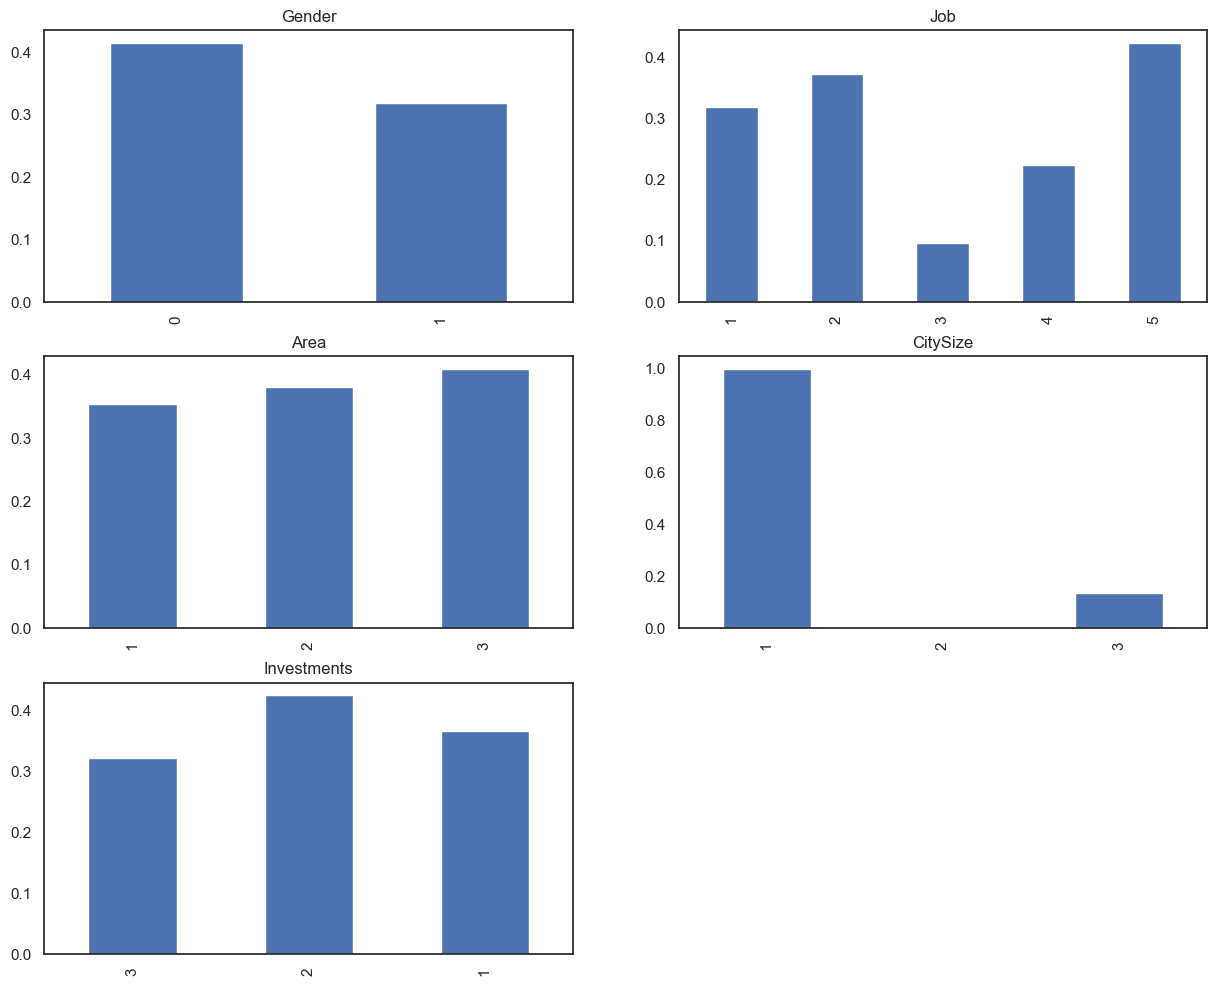

In [22]:
# Histograms of categorical features
%matplotlib inline

plt.figure(figsize = (15,12))

fig = plt.subplot(3, 2, 1)

plt.title('Gender')
(df0['Gender'].value_counts()/df['Gender'].value_counts()).plot(kind='bar')
x = [0,1]
#labels = ['Female', 'Male']
#plt.xticks(x, labels, rotation='horizontal')


plt.subplot(3, 2, 2)

plt.title('Job')
(df0['Job'].value_counts()/df['Job'].value_counts()).plot(kind='bar')
x = [0,1,2,3,4]
#labels = ['imp/op', 'pensionato', 'non occupato', 'qua/dir', 'impr/lib prof']
#plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 3)

plt.title('Area')
(df0['Area'].value_counts()/df['Area'].value_counts()).plot(kind='bar')
x = [0,1,2]
#labels = ['Nord', 'Centro', 'Sud/Isole']
#plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 4)

plt.title('CitySize')
(df0['CitySize'].value_counts()/df['CitySize'].value_counts()).plot(kind='bar')
x = [0,1,2]
#labels = ['Cittadina medie dimensioni', 'Piccolo centro', 'Grande città >200k']
#plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 5)

plt.title('Investments')
(df0['Investments'].value_counts()/df['Investments'].value_counts()).plot(kind='bar')
x = [0,1,2]
#labels = ['Mostly capital accumulation', 'Mostly lump sum', 'No investments']
#plt.xticks(x, labels, rotation='horizontal')

plt.show()

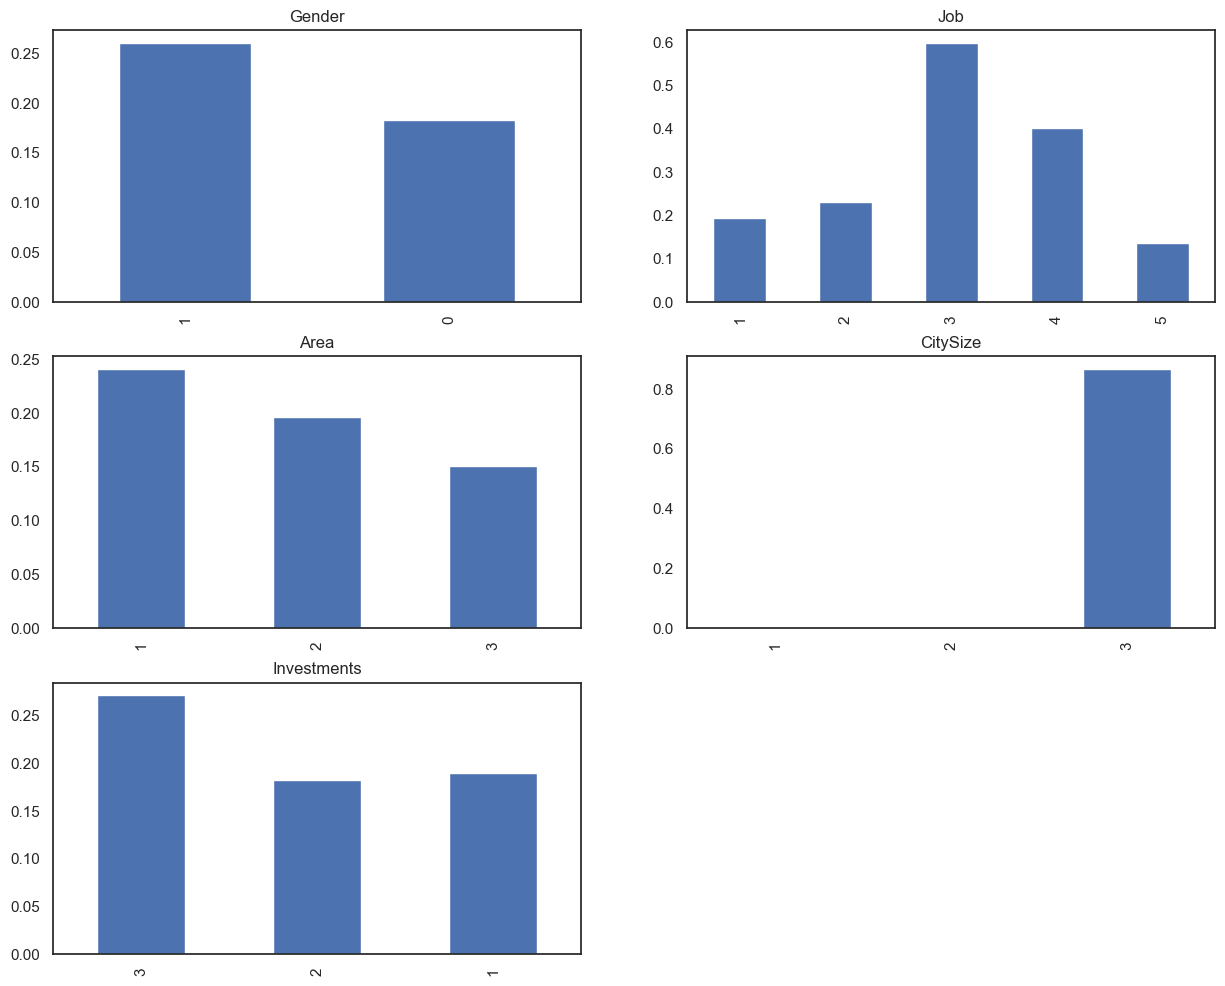

In [23]:
# Histograms of categorical features
%matplotlib inline

plt.figure(figsize = (15,12))

fig = plt.subplot(3, 2, 1)

plt.title('Gender')
(df1['Gender'].value_counts()/df['Gender'].value_counts()).plot(kind='bar')
x = [0,1]
#labels = ['Female', 'Male']
#plt.xticks(x, labels, rotation='horizontal')


plt.subplot(3, 2, 2)

plt.title('Job')
(df1['Job'].value_counts()/df['Job'].value_counts()).plot(kind='bar')
x = [0,1,2,3,4]
#labels = ['imp/op', 'pensionato', 'non occupato', 'qua/dir', 'impr/lib prof']
#plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 3)

plt.title('Area')
(df1['Area'].value_counts()/df['Area'].value_counts()).plot(kind='bar')
x = [0,1,2]
#labels = ['Nord', 'Centro', 'Sud/Isole']
#plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 4)

plt.title('CitySize')
(df1['CitySize'].value_counts()/df['CitySize'].value_counts()).plot(kind='bar')
x = [0,1,2]
#labels = ['Cittadina medie dimensioni', 'Piccolo centro', 'Grande città >200k']
#plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 5)

plt.title('Investments')
(df1['Investments'].value_counts()/df['Investments'].value_counts()).plot(kind='bar')
x = [0,1,2]
#labels = ['Mostly capital accumulation', 'Mostly lump sum', 'No investments']
#plt.xticks(x, labels, rotation='horizontal')

plt.show()

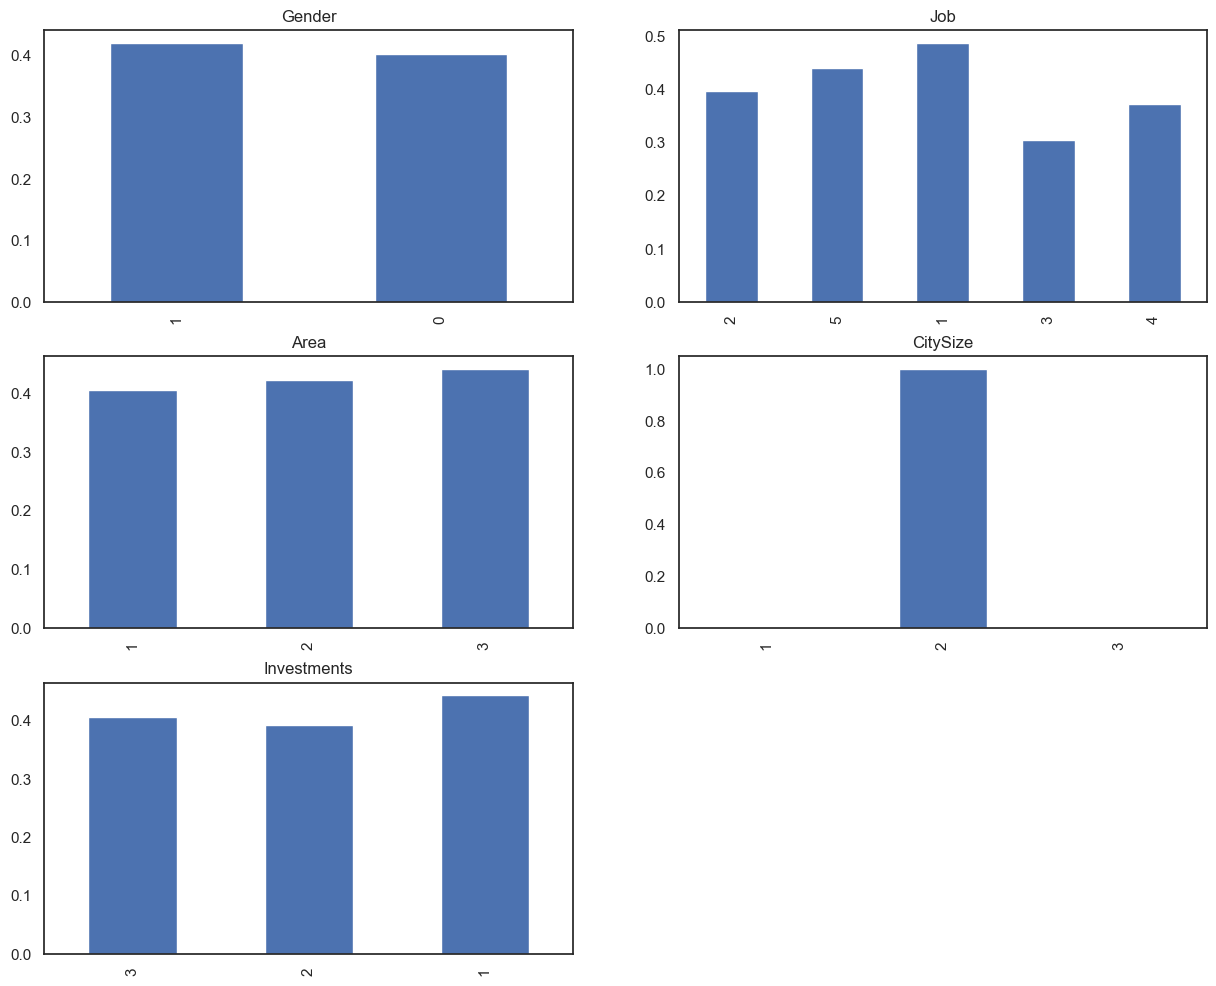

In [24]:
# Histograms of categorical features
%matplotlib inline

plt.figure(figsize = (15,12))

fig = plt.subplot(3, 2, 1)

plt.title('Gender')
(df2['Gender'].value_counts()/df['Gender'].value_counts()).plot(kind='bar')
x = [0,1]
#labels = ['Female', 'Male']
#plt.xticks(x, labels, rotation='horizontal')


plt.subplot(3, 2, 2)

plt.title('Job')
(df2['Job'].value_counts()/df['Job'].value_counts()).plot(kind='bar')
x = [0,1,2,3,4]
#labels = ['imp/op', 'pensionato', 'non occupato', 'qua/dir', 'impr/lib prof']
#plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 3)

plt.title('Area')
(df2['Area'].value_counts()/df['Area'].value_counts()).plot(kind='bar')
x = [0,1,2]
#labels = ['Nord', 'Centro', 'Sud/Isole']
#plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 4)

plt.title('CitySize')
(df2['CitySize'].value_counts()/df['CitySize'].value_counts()).plot(kind='bar')
x = [0,1,2]
#labels = ['Cittadina medie dimensioni', 'Piccolo centro', 'Grande città >200k']
#plt.xticks(x, labels, rotation='horizontal')

plt.subplot(3, 2, 5)

plt.title('Investments')
(df2['Investments'].value_counts()/df['Investments'].value_counts()).plot(kind='bar')
x = [0,1,2]
#labels = ['Mostly capital accumulation', 'Mostly lump sum', 'No investments']
#plt.xticks(x, labels, rotation='horizontal')

plt.show()

In [25]:
col_names = ['Age', 'FamilySize', 'Income', 'Wealth', 'Debt', 
              'FinEdu', 'ESG', 'Digital', 'BankFriend', 'LifeStyle',
              'Luxury', 'Saving']
mean0=df0[col_names].describe()
mean0

,Age,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving
count,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000
mean,63.168681,2.626374,0.543172,0.546139,0.415902,0.480407,0.564207,0.484562,0.603057,0.419653,0.417125,0.512007
std,21.982966,1.422341,0.210122,0.210164,0.221819,0.170845,0.158489,0.194223,0.159566,0.210108,0.224626,0.184688
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.047841,0.070480,0.000000,0.131039,0.000000,0.000000,0.004191
25%,46.000000,1.000000,0.386388,0.385006,0.231200,0.350555,0.444442,0.345246,0.491338,0.253044,0.235700,0.380211
50%,67.000000,2.000000,0.547492,0.558920,0.434020,0.471975,0.571609,0.475268,0.609117,0.387936,0.382186,0.528199
75%,83.000000,4.000000,0.704540,0.705359,0.585836,0.608625,0.688464,0.618430,0.722473,0.567126,0.571033,0.649597
max,95.000000,6.000000,0.983000,0.988747,0.964687,0.944599,0.967210,0.964176,0.958862,0.992283,0.992923,0.965525


In [26]:
mean1=df1[col_names].describe()
mean1

,Age,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving
count,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000
mean,53.519678,2.112701,0.670699,0.673611,0.490916,0.602484,0.649398,0.651077,0.659725,0.584670,0.622095,0.560637
std,18.820432,1.246589,0.194472,0.204739,0.211409,0.190078,0.168643,0.206321,0.169321,0.208708,0.224274,0.175209
min,19.000000,1.000000,0.055185,0.068956,0.000000,0.064139,0.082257,0.011487,0.123195,0.010662,0.041000,0.000000
25%,38.000000,1.000000,0.534423,0.528200,0.351458,0.456776,0.540819,0.516395,0.539064,0.448981,0.479593,0.450425
50%,54.000000,2.000000,0.708970,0.704064,0.512912,0.636889,0.663652,0.705302,0.691725,0.618912,0.658547,0.579566
75%,64.000000,3.000000,0.834977,0.843523,0.641609,0.755024,0.772539,0.812478,0.796170,0.745479,0.799767,0.687675
max,95.000000,6.000000,0.982960,0.995597,0.976912,0.944706,0.989520,0.968395,0.951168,0.962103,0.995914,0.944308


In [27]:
mean2=df2[col_names].describe()
mean2

,Age,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving
count,2062.000000,2062.000000,2062.000000,2062.000000,2062.000000,2062.000000,2062.000000,2062.000000,2062.000000,2062.000000,2062.000000,2062.000000
mean,61.808923,2.570320,0.553239,0.557260,0.408111,0.488435,0.573837,0.498538,0.611157,0.433839,0.446309,0.507735
std,22.409045,1.441619,0.210270,0.208969,0.225779,0.183132,0.166999,0.209272,0.158055,0.213876,0.229894,0.190631
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.043817,0.000000,0.155014,0.000000,0.000000,0.000000
25%,43.000000,1.000000,0.393302,0.401979,0.216122,0.353516,0.454149,0.343935,0.503706,0.267075,0.256072,0.378623
50%,64.000000,2.000000,0.559460,0.560202,0.420691,0.477442,0.585804,0.488360,0.609766,0.408526,0.417501,0.523886
75%,82.000000,4.000000,0.720444,0.717482,0.583780,0.614408,0.695133,0.650662,0.732604,0.588868,0.617681,0.654067
max,95.000000,6.000000,0.973385,0.992805,0.949032,0.962526,0.987084,0.971778,0.974230,0.978586,0.983324,0.961016
